# Spotify Song Popularity Analysis
***

This notebook analyses the ['Spotify_1Million_Tracks' dataset from Kaggle](https://www.kaggle.com/datasets/amitanshjoshi/spotify-1million-tracks). We'll explore the dataset initally to decide what direction the analysis should take.

|Feature|Description|
|-------|-----------|
|track_id|The Spotify ID for the track.|
|artist_name|The name of the artist.|
|track_name|The name of the track.|
|popularity|Popularity of the track on a scale from 0-100.|
|year|Release year of the track from between 2000 and 2023.|
|genre|The genre of the track|
|dancability|Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.|
|energy|Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.|
|key|The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.|
|loundness|The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.|
|mode|Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.|
|speechiness|Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.|
|acousticness|A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.|
|instrumentalness|Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.|
|liveness|Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.|
|valence|A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).|
|tempo|The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.|
|duration_ms|The duration of the track in milliseconds.|
|time_signature|An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".|

***
## Table of Contents
1. [Importing Libraries](#import_lib)
2. [Importing and cleaning the data](#import_and_clean)
    1. [Importing data](#import_data)
    2. [Cleaning](#cleaning)
3. [Exploratory Data Analysis](#eda)
    1. [Histogram: Tracks per year](#hist_tracks_per_year)
    2. [Barplot: Frequency of genres](#bar_genre_freq)
    3. [Histogram: Track length, Popularity, Tempo and Key](#hist_other)
4. [Further cleaning](#further_cleaning)
5. [Comparison to my music taste](#my_music_compare)
6. [Classifying my music taste](#my_music_classify)
    1. [Results](#my_music_results)
    2. [Applying the model](#my_music_apply)
        1. [Known album](#my_music_apply_known)
        2. [Unknown album](#my_music_apply_unknown)
    3. [Reflecting on the model](#my_music_reflect)
***

# Importing libraries<a name="import_lib"></a>
***

First we'll be needing to access the Spotify API, which we can conveniantly do via the Python API Spotipy. We'll install it, import a

In [1]:
!pip install spotipy

In [2]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
import pylab as py
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette="deep")

import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [3]:
with open('credentials.json') as f:
    data = json.load(f)
    SPOTIPY_CLIENT_ID = data['SPOTIPY_CLIENT_ID']
    SPOTIPY_CLIENT_SECRET = data['SPOTIPY_CLIENT_SECRET']

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET))

We'll run a quick test to ensure we've set up the API properly by calling for a list of albumns by King Gizzard and the Lizard Wizard.

In [4]:
gizz_uri = 'spotify:artist:6XYvaoDGE0VmRt83Jss9Sn'

results = spotify.artist_albums(gizz_uri, album_type='album')
albums = results['items']
while results['next']:
    results = spotify.next(results)
    albums.extend(results['items'])

for album in albums:
    print(album['name'])

PetroDragonic Apocalypse; or, Dawn of Eternal Night: An Annihilation of Planet Earth and the Beginning of Merciless Damnation
Changes
Laminated Denim
Ice, Death, Planets, Lungs, Mushrooms And Lava
Omnium Gatherum
Made In Timeland
Butterfly 3001
Butterfly 3000
L.W.
Live In San Francisco '16
K.G.
Chunky Shrapnel
Infest The Rats' Nest
Fishing For Fishies
Gumboot Soup
Polygondwanaland
Sketches of Brunswick East
Murder of the Universe
Flying Microtonal Banana
Nonagon Infinity
Paper Mâché Dream Balloon (Original + Instrumental)
Quarters
I'm in Your Mind Fuzz
Oddments
Float Along - Fill Your Lungs
Eyes Like The Sky
12 Bar Bruise
Willoughby's Beach


This is working great.

# Importing and cleaning the data <a name="import_and_clean"></a>
***

### Importing data<a name="import_data"></a>

Now for the data. We already have the dataset downlaoded, so we'll read it straight into a pandas dataframe

In [5]:
data = pd.read_csv("spotify_data.csv", header=0, delimiter=",")
data.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


The `Unnamed: 0` column represents a unique identifier for each song in the .csv file. We already have `track_id` to do this, so we'll drop the first column, and set `track_id` to be the index.

In [6]:
data = data.drop(["Unnamed: 0"], axis=1)

In [7]:
data.head()

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


### Cleaning <a name="cleaning"></a>

According to the Kaggle page, the data has already been cleaned, which makes sense from the numerous features scaled between 0 and 1 already, but we'll still check ourselves.

In [8]:
data.isnull().sum()

artist_name         15
track_name           1
track_id             0
popularity           0
year                 0
genre                0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

There are 15 tracks without an artist name, and 1 without a track_name. Let's pull up those entries.

In [9]:
data[data.isnull().any(axis=1)]

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
256971,NaN,Cold,10eyeJsKDh26SKEBvSfuBG,17,2017,black-metal,0.2120,0.7080,7,-6.932,1,0.2180,0.000201,0.9060,0.1430,0.0381,126.739,717237,4
256972,NaN,Wither,6xz1O7tOw6Tdvzc3Ev1isc,16,2017,black-metal,0.3170,0.5180,9,-7.418,1,0.0650,0.000258,0.8550,0.7290,0.0747,110.958,525099,4
257024,NaN,Suffer,6hedSqpvIaW0GzrqJnq32D,14,2017,black-metal,0.1090,0.1420,2,-11.807,0,0.0439,0.154000,0.8790,0.1050,0.0350,57.422,565664,3
313028,NaN,"A World, Dead and Gray",7shu4LrpMTsGwa8YotA1My,26,2018,black-metal,0.3770,0.5070,7,-14.889,1,0.0448,0.000103,0.9310,0.2110,0.3380,113.917,466182,4
313050,NaN,Hypoxic,3V8qpQnLVhu82ZvC4Ja8VG,24,2018,black-metal,0.3410,0.4260,11,-17.450,0,0.0496,0.038000,0.8480,0.1130,0.0404,66.628,418945,4
313063,NaN,Bed the Cold Earth,68w6nJMmA9Ui6zV7qXrwIt,22,2018,black-metal,0.1650,0.4610,10,-16.267,1,0.0378,0.001410,0.7890,0.1030,0.1220,72.501,464632,4
313117,NaN,Life Is Long Enough,1NJ8HTD5syI65EJmXUckxB,20,2018,black-metal,0.1800,0.1400,7,-18.017,0,0.0440,0.230000,0.9250,0.1110,0.0357,86.924,476152,4
313153,NaN,Corroded,4zcJ5p91PSG3vDsGJfENDd,17,2018,black-metal,0.1490,0.1440,2,-21.518,0,0.0321,0.771000,0.8590,0.1120,0.0398,85.413,317214,4
313174,NaN,Desiderate,6375ZIE3Pi8BuZOuy8f6g1,16,2018,black-metal,0.1630,0.3210,7,-17.123,0,0.0411,0.148000,0.3240,0.1140,0.0535,66.017,472719,4
313225,NaN,Where Life Should Be,0VCAJwhy4p3tVaGUSnaWGr,15,2018,black-metal,0.1910,0.1630,0,-15.242,0,0.0378,0.102000,0.9070,0.0875,0.0383,137.785,530210,3


In over 1 million tracks, 16 won't be missed so we'll simply remove these.

In [10]:
data = data.dropna(axis=0)
data.isnull().sum()

artist_name         0
track_name          0
track_id            0
popularity          0
year                0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

No more missing values. Now we'll check data types.

In [11]:
data.dtypes

artist_name          object
track_name           object
track_id             object
popularity            int64
year                  int64
genre                object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
dtype: object

These are all appropriate so we can now continue with some exploratory analysis.

# Exploratory Data Analysis <a name="eda"></a>
***

### Histogram: Tracks per year <a name="hist_tracks_per_year"></a>

We know the tracks are from the last 23 years of music, but let's look at their distribution over those years.

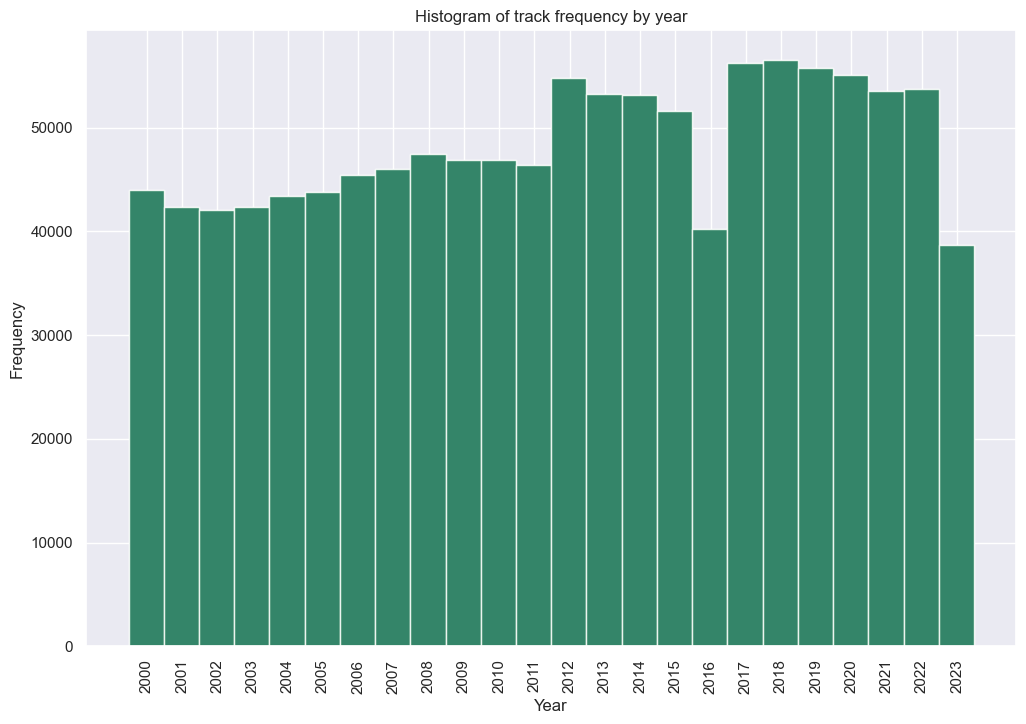

In [12]:
# Get tick values and labels
n, bins, patches = plt.hist(data["year"], bins=24)
ticks = [(patch.get_x() + patch.get_x())/2 + 0.5 for patch in patches]
ticklabels = [i for i in data["year"].sort_values().unique()]

# Histogram
data["year"].plot(kind="hist", 
                  figsize=(12,8), 
                  rot=90, bins=24, 
                  color = "seagreen",
                  alpha=0.8)

# Prettify
plt.xticks(ticks, ticklabels)
plt.title('Histogram of track frequency by year') 
plt.ylabel('Frequency') 
plt.xlabel('Year')

plt.show()

The distribution of tracks in the data from the last 23 years seems fairly uniform. We'll pick out some other features and create some more histograms.

### Barplot: Frequency of genres <a name="bar_genre_freq"></a>

In [13]:
genre_count = pd.DataFrame(data.groupby("genre").count().rename(columns={"artist_name": "count"})["count"])

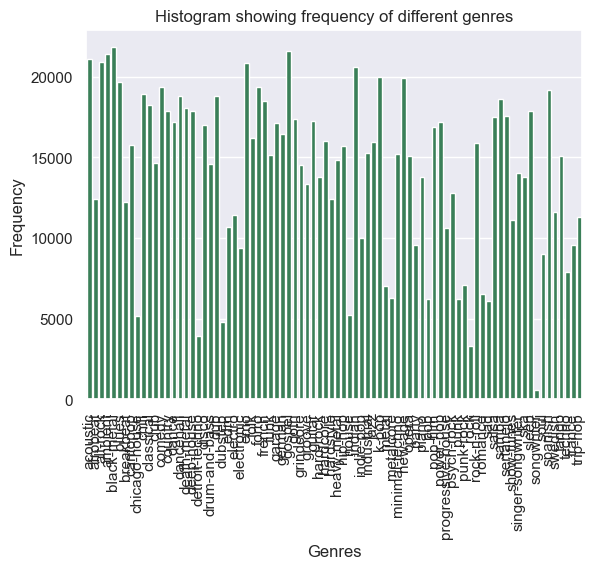

In [14]:
plt.subplot(111)
sns.barplot(data = genre_count,
            x = genre_count.index,
            y = "count",
            color = "seagreen")
sns.set(rc={'figure.figsize':(15.7,8.27)})
plt.title('Histogram showing frequency of different genres') 
plt.ylabel('Frequency') 
plt.xlabel('Genres')
plt.tick_params(axis='x', labelrotation = 90)

The most and least popular genres are:

|Most popular (>20000)|Least popular (<5000)|
|---------------------|---------------------|
|acoustic|chicago-house|
|alt-rock|detroit-techno|
|ambient|dubstep|
|black-metal|house|
|emo|rock|
|gospel|songwriter|
|indian|

In [15]:
data.head()

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


### Histogram: Track length, Popularity, Tempo and Key <a name="hist_other"></a>

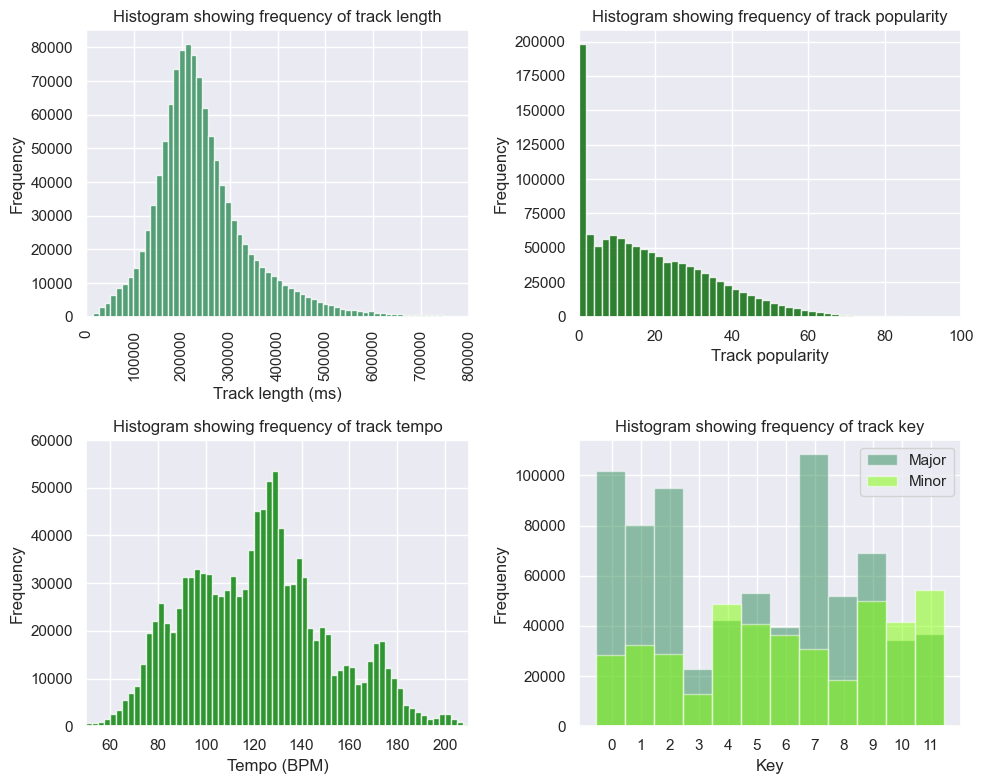

In [16]:
### Duration
plt.subplot(221)
data["duration_ms"].plot(kind="hist", 
                  figsize = (10,8), 
                  rot = 90, 
                  bins = 500,
                  color = "seagreen",
                  alpha = 0.8)
plt.xlim(xmin=0, xmax = 0.8e6)
plt.title('Histogram showing frequency of track length') 
plt.ylabel('Frequency') 
plt.xlabel('Track length (ms)')

### Popularity
plt.subplot(222)
data["popularity"].plot(kind="hist", 
                  figsize = (10,8), 
                  rot = 0, 
                  bins = 50,
                  color = "darkgreen",
                  alpha = 0.8)
plt.xlim(xmin=0, xmax = 100)
plt.title('Histogram showing frequency of track popularity') 
plt.ylabel('Frequency') 
plt.xlabel('Track popularity')

### Tempo
plt.subplot(223)
data["tempo"].plot(kind="hist", 
                  figsize = (10,8), 
                  rot = 0, 
                  bins = 100,
                  color = "green",
                  alpha = 0.8)
plt.xlim(xmin=50, xmax = 210)
plt.ylim(ymin=0, ymax=60000)
plt.title('Histogram showing frequency of track tempo') 
plt.ylabel('Frequency') 
plt.xlabel('Tempo (BPM)')

### Key
data_maj = data[data["mode"] == 1]["key"].reset_index()
data_min = data[data["mode"] == 0]["key"].reset_index()

# Get tick values
n, bins, patches = plt.hist(data["key"], bins=12)
ticks = [(patch.get_x() + patch.get_x())/2 + 0.5 for patch in patches]
ticklabels = [i for i in data["key"].sort_values().unique()]

plt.subplot(224)
data_maj["key"].plot(kind="hist",
                     figsize = (10,8), 
                     rot = 0, 
                     bins = 12,
                     color = "seagreen",
                     alpha = 0.5,
                     label = "Major")
data_min["key"].plot(kind="hist",
                     figsize = (10,8), 
                     rot = 0, 
                     bins = 12,
                     color = "chartreuse",
                     alpha = 0.5,
                     label = "Minor")
plt.xticks(ticks, ticklabels)
plt.title('Histogram showing frequency of track key') 
plt.ylabel('Frequency') 
plt.xlabel('Key')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

- The distribution of track length looks close to normally distributed. We could test this separately with a distribution plot.
- The split of key into separate majors and minors could be cleaned up. We could instead have 24 variables, and name them appropriately, i.e. for major {0: "C", 1: "G",...} and for minor {0: "a", 1: "e",...} (see [wikipedia page](https://en.wikipedia.org/wiki/Key_signature))
- There seems to be an abnormal amount of tracks with 0 popularity. This should be investigated.

# Further cleaning  <a name="further_cleaning"></a>

The EDA has revealed some irregularities in the data that need sorting out. Firstly, there is clearly a problem regarding track `popularity`, which has an overwhelming number of tracks with a score of 0. This issue is repeated in `acousticness` and `instrumentalness` which can be seen here.

In [20]:
def hist_matrix(df, x_list, label, grid):
    '''
    A specialised histogram plotter for this dataset.
    
    df:     the dataframe which the data belongs too
    x_list: the columns in the dataframe to be plotted 
    label:  0 for other music after 'my_tracks' added, 1 for my music, -1 to skip labelling
    grid:   the size of the grid to make subplots on, [rows, columns]
    
    '''

    try:
        # My music
        if label == 1:
            lab = "My top songs"
            data = df[df['my_track'] == label]
        # Million Tracks music
        elif label == 0:
            lab = "Other music"
            data = df[df['my_track'] == label]
        # Ignore labels
        elif label == -1:
            lab = None
            data = df
            

        for plot_num, x in enumerate(x_list):
            plt.subplot(grid[0],grid[1],plot_num+1)
            sns.histplot(data=data, x=x, kde=True, stat='density', alpha=0.5, label=lab)
            plt.ylabel("")
            plt.xlabel(x.upper())
            print(lab, x, "plot complete")

            
    except UnboundLocalError:
        print("Invalid label value. 'my_tracks' label must be a 1, 0 or -1, for my music, Million Tracks music or skip labels respectively")
    except KeyError:
        print("Try skipping label issues with label=-1")

None popularity plot complete
None acousticness plot complete
None instrumentalness plot complete


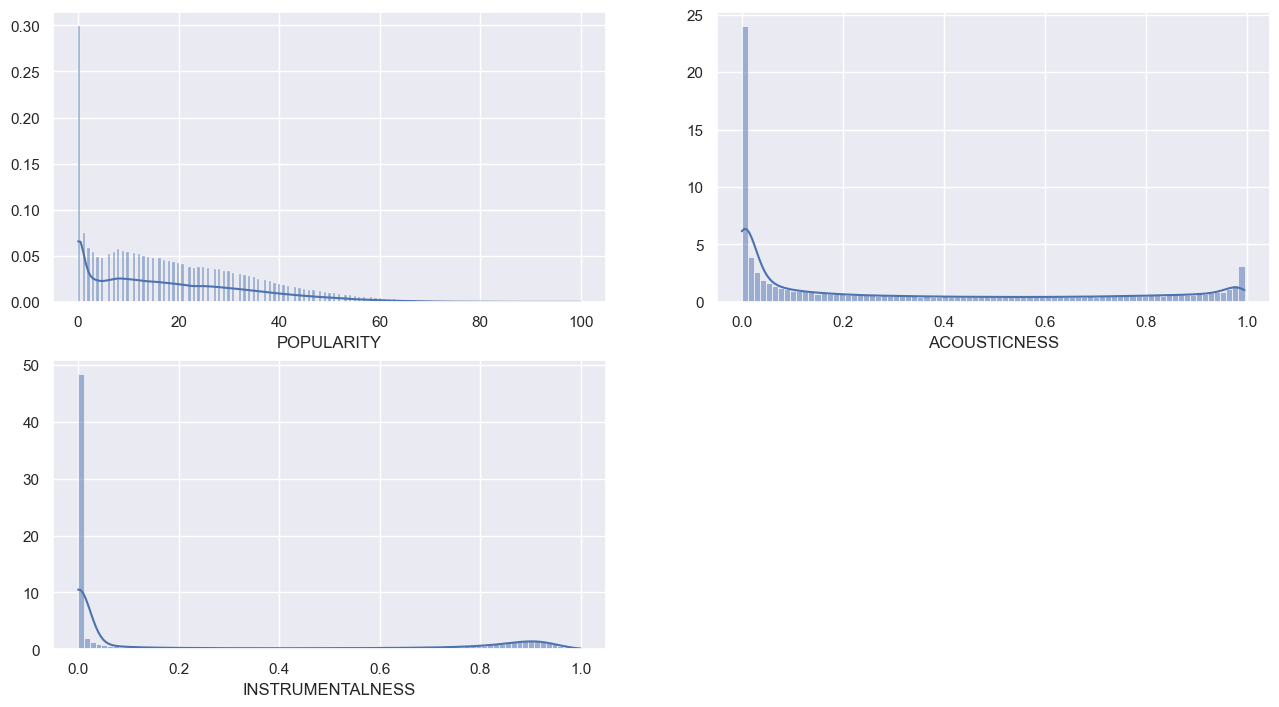

In [21]:
x_list = ["popularity", "acousticness", "instrumentalness"]
grid = [2,2]

hist_matrix(data, x_list, -1, grid)

In [22]:
issues = ['popularity', 'acousticness', 'instrumentalness']

for i in issues:
    print("{:.2f}% of the".format(data[data[i] == 0].shape[0]/data.shape[0] * 100), i, "data has a value of 0 ({:.0f} entries)".format(data[data[i] == 0].shape[0]))

13.66% of the popularity data has a value of 0 (158391 entries)
0.06% of the acousticness data has a value of 0 (717 entries)
24.85% of the instrumentalness data has a value of 0 (288224 entries)


Recall from the table at the beginning of this notebook that `instrumentalness` and `acousticness` are confidence measures. 
- `acousticness` is simpler, being that a value closer to 1 means Spotify has more confidence that it is an acoustic track. 
- `instrumentalness` is only a little more complicated: values over 0.5 are meant to indicate that Spotify believes they are instrumental tracks, with more confidence closer to 1, and values under 0.5 are meant to represent vocal or non-instrumental tracks. It counts "oooh"'s and "ahhh"'s as instrumental, i.e. not vocal.

Importantly it is the confidence measure that is of key importance - a confidence measure of 0 on a track simply means Spotify is *certain* it is not acoustic (and similarly for instrumental). Thus it could be more helpful for this analysis to represent these features as a 1 or a 0 - it either is or is not acoustic/instrumental. Of notable importance, **values of 0.5 will be rounded up to 1**.

This loses some nuance of the data, in the confidence Spotify has in it's decision, but overall it will help to remove the extreme biases presented in the histograms.

In [23]:
for col in ["acousticness", "instrumentalness"]:
    data[col] = data.loc[data[col] >= 0.5, col] = 1
    data[col] = data.loc[data[col] < 0.5, col] = 0
    data[col] = data[col].astype("int32")
    print(f"Successfully made {col} binary")

Successfully made acousticness binary
Successfully made instrumentalness binary


In fact, `liveness` is also a confidence measure, so could be encoded this way too, but since it has a wider distribution to be worked with, this will be kept as it is.

# Comparison to my music taste <a name="my_music_compare"></a>

I want to be able to make a comparison between my music taste and the general music from this data set. I'll do this by importing a preprocessed dataframe of my top 99 songs in the past 6 months, and add an indicator feature representing it's my music. All entries from the 1 Million Tracks data will be given a value of 0.

In [24]:
my_music = pd.read_csv("my_music_prepro.csv").drop("Unnamed: 0", axis=1)

In [25]:
my_music['my_track']=1
my_music

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_s,my_track
0,0.661,0.713,0,-8.393,0,0.0723,0,0,0.367,0.433,124.005,4,117.347,1
1,0.791,0.267,5,-11.997,1,0.0415,1,1,0.102,0.544,165.990,4,215.111,1
2,0.438,0.495,1,-9.697,0,0.0742,0,0,0.160,0.778,166.851,5,212.966,1
3,0.577,0.747,11,-9.884,0,0.1830,0,0,0.175,0.713,158.853,4,76.347,1
4,0.233,0.933,6,-5.804,1,0.0572,0,1,0.101,0.420,95.972,3,191.320,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.407,0.899,2,-6.238,1,0.1150,0,0,0.126,0.142,115.005,4,159.080,1
95,0.620,0.618,11,-7.480,0,0.0450,0,0,0.131,0.935,165.248,4,172.211,1
96,0.521,0.902,11,-6.876,0,0.0469,0,0,0.866,0.669,141.223,4,299.093,1
97,0.548,0.963,5,-4.320,1,0.0554,0,0,0.104,0.856,110.352,4,615.939,1


To make a direct comparison, I'll process the Million Tracks data to have the same features.

In [26]:
million_tracks = data.copy()

million_tracks['duration_s'] = million_tracks['duration_ms']/1000
million_tracks['my_track'] = 0

million_tracks = million_tracks.drop(['track_id','artist_name','track_name','track_id','popularity','year','genre','duration_ms'], axis=1)

In [27]:
million_tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_s,my_track
0,0.483,0.303,4,-10.058,1,0.0429,0,0,0.1150,0.1390,133.406,3,240.166,0
1,0.572,0.454,3,-10.286,1,0.0258,0,0,0.0974,0.5150,140.182,4,216.387,0
2,0.409,0.234,3,-13.711,1,0.0323,0,0,0.0895,0.1450,139.832,4,158.960,0
3,0.392,0.251,10,-9.845,1,0.0363,0,0,0.0797,0.5080,204.961,4,304.293,0
4,0.430,0.791,6,-5.419,0,0.0302,0,0,0.1100,0.2170,171.864,4,244.320,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,0.373,0.742,10,-6.453,0,0.0736,0,0,0.1590,0.5220,107.951,3,344.013,0
1159760,0.516,0.675,7,-7.588,0,0.0326,0,0,0.1300,0.2640,119.897,4,285.067,0
1159761,0.491,0.440,5,-8.512,1,0.0274,0,0,0.0936,0.0351,100.076,4,214.253,0
1159762,0.480,0.405,0,-13.343,1,0.0276,0,0,0.1250,0.2020,133.885,3,239.133,0


Now I can combine them in a histogram matrix using the function defined earlier.

In [28]:
X = pd.concat([my_music, million_tracks], axis=0).sample(frac=1.0)

My top songs danceability plot complete
My top songs energy plot complete
My top songs loudness plot complete
My top songs speechiness plot complete
My top songs liveness plot complete
My top songs valence plot complete
My top songs tempo plot complete
My top songs duration_s plot complete
Other music danceability plot complete
Other music energy plot complete
Other music loudness plot complete
Other music speechiness plot complete
Other music liveness plot complete
Other music valence plot complete
Other music tempo plot complete
Other music duration_s plot complete


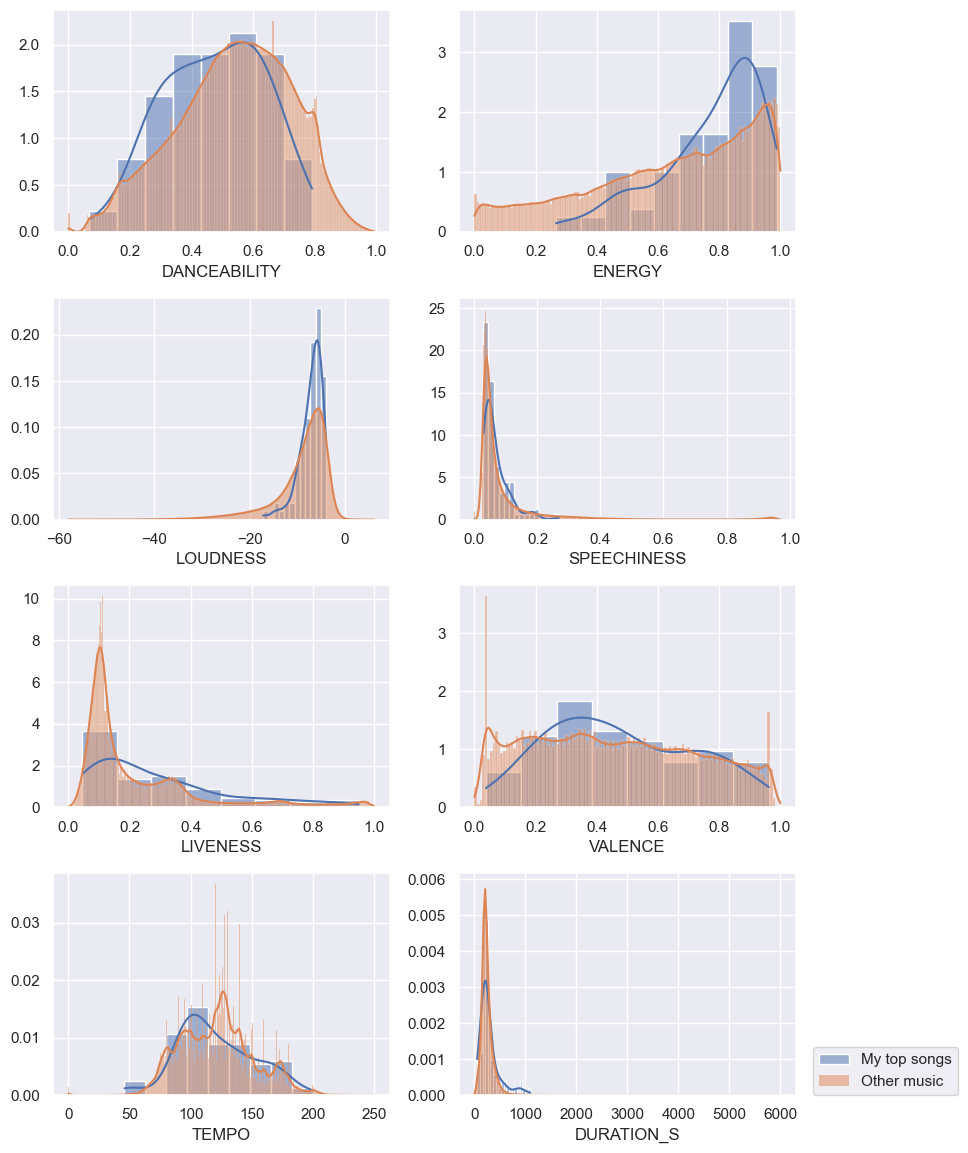

In [29]:
x_list = ["danceability",
          "energy",
          "loudness",
          "speechiness",
          "liveness",
          "valence",
          "tempo",
          "duration_s"]
grid=[4,2]

plt.figure(figsize=(8.27,11.69))

hist_matrix(X, x_list, 1, grid)
hist_matrix(X, x_list, 0, grid)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
plt.show()

In [30]:
X[X['my_track'] == 1]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_s,my_track
12,0.269,0.885,11,-5.938,0,0.0948,0,1,0.1320,0.325,129.191,4,251.720,1
60,0.423,0.458,4,-14.900,1,0.0510,1,1,0.3270,0.187,117.194,3,80.000,1
52,0.348,0.797,2,-7.858,1,0.0987,0,0,0.7590,0.229,169.562,3,210.840,1
35,0.552,0.929,6,-6.997,1,0.1020,0,1,0.1040,0.706,103.433,3,170.240,1
57,0.674,0.712,0,-5.338,1,0.0888,0,1,0.1650,0.575,89.980,4,194.632,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.560,0.715,7,-7.937,1,0.0313,0,1,0.0745,0.767,126.331,4,228.360,1
36,0.547,0.647,11,-8.530,0,0.0728,0,1,0.1000,0.404,166.214,4,220.217,1
38,0.415,0.891,11,-5.442,0,0.0468,0,1,0.8750,0.512,96.283,4,294.840,1
30,0.297,0.852,7,-5.509,1,0.0495,0,0,0.7390,0.269,106.998,1,241.160,1


Some insights from this comparison:
- My music taste is more focused on energetic, loud music.
- My music taste is slightly less danceable.
- I listen to more music with longer tracks.

# Classifying my music taste <a name="my_music_classify"></a>

Next I want to build a classifier that can predict if a song will be in my top tracks, i.e. if I'll like it. 

In [31]:
y = X['my_track']
X = X.drop('my_track', axis=1)

In [32]:
def split_and_transform(X,y):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)
    
    # Standardize X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [33]:
X_train, X_test, y_train, y_test = split_and_transform(X,y)

In [34]:
models = {
    "                   Logistic Regression":LogisticRegression(),
    "                   K-Nearest Neighbors":KNeighborsClassifier(),
    "                         Decision Tree":DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)":LinearSVC(),
    "                         Random Forest":RandomForestClassifier()
    
}
#    "   Support Vector Machine (RBF Kernel)":SVC(),

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.


C:\Users\edwar\anaconda3\envs\coursera-env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\edwar\anaconda3\envs\coursera-env\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Support Vector Machine (Linear Kernel) trained.
                         Random Forest trained.


## Results <a name="my_music_results"></a>

In [35]:
for name, model in models.items():
    print(name + ": {:.2f}%".format(model.score(X_test, y_test) * 100))

                   Logistic Regression: 99.99%
                   K-Nearest Neighbors: 99.99%
                         Decision Tree: 99.99%
Support Vector Machine (Linear Kernel): 99.99%
                         Random Forest: 99.99%


All classifiers work well with an accuracy score of 99.99%.

## Applying the model <a name="my_music_apply"></a>

### Known album <a name="my_music_apply_known"></a>

I know that most of my top 100 songs were by King Gizzard and the Lizard Wizard. I'm going to see if, based on audio features alone, whether or not any tracks in their new album would make my 'Top 100' playlist.

In [36]:
def get_album_ids(album_id):
    '''
    Returns all track IDs for a given album
    '''
    r = spotify.album_tracks(album_id)
    t = r['items']
    ids = []
    
    for s in range(len(t)):
        ids.append(t[s]['id'])
    
    return ids

In [37]:
album = get_album_ids('53X6xpjjMDMfZ5IWMyonvC')
album_features = pd.DataFrame(spotify.audio_features(album)).sample(frac=1.0, random_state=1).reset_index(drop=True)
album_features['duration_s'] = album_features['duration_ms'] / 1000
album_features.drop(['type', 'uri', 'track_href', 'analysis_url', 'duration_ms'], inplace=True, axis=1)

In [38]:
album_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,time_signature,duration_s
0,0.384,0.948,7,-7.589,1,0.0836,0.000119,0.103000,0.0865,0.240,90.758,5XkNUvzFQUCBu39tWRVO15,4,561.158
1,0.559,0.925,11,-6.092,0,0.0405,0.000083,0.004140,0.2030,0.507,107.551,00p8kaZMs7umxsVrBqarlt,3,376.370
2,0.494,0.956,1,-5.908,1,0.0587,0.000028,0.059100,0.4190,0.313,137.729,0gGr4hnPoYgOq7ccAh148N,3,305.862
3,0.315,0.948,4,-6.696,1,0.1230,0.000901,0.081600,0.4510,0.286,106.485,4HAkFNSjf5edeuY839m1RD,5,512.898
4,0.544,0.965,0,-5.726,1,0.0814,0.000335,0.000000,0.4950,0.371,125.066,3M48swVS1NBX5V4SLESekp,4,275.774
5,0.532,0.939,2,-5.883,1,0.0323,0.000054,0.000698,0.4750,0.741,102.270,0mQU3EuOIqMpRg4qbXDxda,3,303.696
6,0.517,0.965,4,-5.970,1,0.1010,0.000014,0.077900,0.2230,0.558,145.176,4A003vQ5hw24V0WajOageQ,4,584.700


In [39]:
for name, model in models.items():
    print(name, model.predict(album_features.drop(['id'], axis=1)))

                   Logistic Regression [1 1 0 1 0 0 1]
                   K-Nearest Neighbors [0 0 0 0 0 0 0]
                         Decision Tree [0 0 0 0 0 0 0]
Support Vector Machine (Linear Kernel) [0 0 0 0 0 0 0]
                         Random Forest [0 0 0 0 0 0 0]


Only the logistic regression model predicts any of these songs will make my top 100. The songs it chooses are the first, fourth and seventh track. I know what these are, but let's use the API to pull the info on these tracks.

In [40]:
def get_song_name(track_id):
    '''
    Returns the name of a song for a given track_id
    '''
    track = spotify.track(track_id)
    name = track['name']
    
    return name

In [41]:
for idx, track in enumerate(range(len(album_features))):
    track_id = album_features.iloc[track]['id']

    print(f"{idx+1}.", get_song_name(track_id))

1. Flamethrower
2. Converge
3. Supercell
4. Motor Spirit
5. Gila Monster
6. Witchcraft
7. Dragon


In fact I didn't know what these tracks were: this isn't the order the actual album is in, but it's the order listed by our classifier. Thus the logistic regression model thinks I'll like 
- Flamethrower
- Motor Spirit
- Dragon

the most on the album. Infact this is almost true - those are some of my favrouite songs on the album, but it misses my actual favrouite track "Witchcraft".

### Unseen album <a name="my_music_apply_unknown"></a>

But I've already listened to that album. What about a new album I haven't heard - will my logistic regression classifier be able to pick out the best songs for me on an album? I'll use Nothing But Thieves' new album 'Dead Club City'.

In [42]:
album = get_album_ids('0kqOkJ9HCUD4AXKvvR6lb7')
album_features = pd.DataFrame(spotify.audio_features(album)).sample(frac=1.0, random_state=1).reset_index(drop=True)
album_features['duration_s'] = album_features['duration_ms'] / 1000
album_features.drop(['type', 'uri', 'track_href', 'analysis_url', 'duration_ms'], inplace=True, axis=1)

for name, model in models.items():
    print(name, model.predict(album_features.drop(['id'], axis=1)))
    
for idx, track in enumerate(range(len(album_features))):
    track_id = album_features.iloc[track]['id']

    print(f"{idx+1}.", get_song_name(track_id))

                   Logistic Regression [0 0 0 0 0 0 0 0 0 0 0]
                   K-Nearest Neighbors [0 0 0 0 0 0 0 0 0 0 0]
                         Decision Tree [0 0 0 0 0 0 0 0 0 0 0]
Support Vector Machine (Linear Kernel) [0 0 0 0 0 0 0 0 0 0 0]
                         Random Forest [0 0 0 0 0 0 0 0 0 0 0]
1. Tomorrow Is Closed
2. Keeping You Around
3. City Haunts
4. Talking To Myself
5. Overcome
6. Members Only
7. Welcome to the DCC
8. Green Eyes :: Siena
9. Pop The Balloon
10. Foreign Language
11. Do You Love Me Yet?


None of the classifiers think I'll like any of the songs on this album.

## Reflecting on the model <a name="my_music_reflect"></a>

The model predicted I wouldn't like any of the songs on this album which, after listening to it, is *not true*. Why did this happen? Here are my thoughts:

The model predicts which songs will be in my *top 100*. Maybe even though I like some songs on the album, I don't like them enough to make the top 100. 
- Thus the metric I have used to see if I will like a song is **flawed**.
    
In comparison to the over one million songs of the 'Million Tracks' data, my top 100 playlist only contains that, 100 songs. This means the 'Million Tracks' data accounts for 99.99% of the tracks being analysed which is a **massive bias** to the model. 
- Taking a random sample of say 1000 songs from the 'Million Tracks' data and repeating the analysis again could resolve this. I could then repeat this many times, taking many different samples, and average their results.

## Author

Ted Binns